# AILab 画像分類コンペティション

## ルール
検証にCIFAR10のValデータは使わないでください。

(今回評価用のデータとして用いるため)

モデルを評価する際は、Trainデータを分割して使ってください。

In [23]:
#ライブラリのインポート
import torch as torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchsummary import summary
from pylab import rcParams


from utils import make_dataset
from utils import eval
from torch.optim.lr_scheduler import ReduceLROnPlateau

### 1.1. データセットの読み込み（改変不可）
- pytorchではデータをTensor形式で扱います。(listやnumpyと似たような構造を持つ)

In [24]:
#このセルは改変しないで
train_dataset=make_dataset()

Files already downloaded and verified


### 1.2. データセットの可視化

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear)
               ToTensor()
           )
学習画像サイズ torch.Size([3, 64, 64])
ラベル: 9


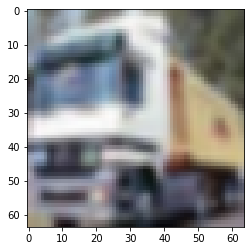

In [25]:
%matplotlib inline
def show(img):
    npimg = img.numpy() 
    plt.grid(False) 
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

print (train_dataset)
image, label = train_dataset[1]
print("学習画像サイズ",image.size())
print ("ラベル:",label)
show(image)

### 1.3. データセットをミニバッチ単位に変換します。
- **torch.utils.data.DataLoader**クラスで行います。

In [26]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, #バッチサイズの定義
                                           shuffle=True,
                                          num_workers=1)


In [27]:
# Data Augmentation
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

## 2.モデルの定義
### 2.1. モデルの定義(nn.Moduleを継承したクラスでの書き方)
- **__init__**関数でネットワーク層の定義、初期化を行います。
- **forward**関数でモデルの入力→出力の定義、順伝搬の計算を行います。  
    - 定義したネットワーク層に入力(x)を伝搬していきます。
- 全結合ネットワークは**nn.Liner(入力パラメータ数、出力パラメータ数)**で定義します。
    - 画像データを扱う場合、入力パラメータ数は**二次元データを一次元に変換**して入力します。
    - Tensorのサイズ変換には**Tensor.view(軸について要素数を指定)**を用います。

In [28]:
class Bottleneck(nn.Module):
    """
    Bottleneckを使用したresidual blockクラス
    """
    def __init__(self, indim, outdim, is_first_resblock=False):
        super(Bottleneck, self).__init__()
        self.is_dim_changed = (indim != outdim)
        # W, Hを小さくしてCを増やす際はstrideを2にする +
        # projection shortcutを使う様にセット
        if self.is_dim_changed:
            if is_first_resblock:
                # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
                stride = 1
            else:
                stride = 2
            self.shortcut = nn.Conv2d(indim, outdim, 1, stride=stride)
        else:
            stride = 1
        
        dim_inter = int(outdim / 4)
        self.conv1 = nn.Conv2d(indim, dim_inter , 1)
        self.bn1 = nn.BatchNorm2d(dim_inter)
        self.conv2 = nn.Conv2d(dim_inter, dim_inter, 3,
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(dim_inter)
        self.conv3 = nn.Conv2d(dim_inter, outdim, 1)
        self.bn3 = nn.BatchNorm2d(outdim)
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        shortcut = x
  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        # Projection shortcutの場合
        if self.is_dim_changed:
            shortcut = self.shortcut(x)

        out += shortcut
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    
    def __init__(self): 
          
        super(ResNet50, self).__init__()
        
        # Due to memory limitation, images will be resized on-the-fly.
        self.upsampler = nn.Upsample(size=(224, 224))

        # Prior block
        self.layer_1 = nn.Conv2d(3, 64, 7, padding=3, stride=2)
        self.bn_1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Residual blocks
        self.resblock1 = Bottleneck(64, 256, True)
        self.resblock2 = Bottleneck(256, 256)
        self.resblock3 = Bottleneck(256, 256)
        self.resblock4 = Bottleneck(256, 512)
        self.resblock5 = Bottleneck(512, 512)
        self.resblock6 = Bottleneck(512, 512)
        self.resblock7 = Bottleneck(512, 512)
        self.resblock8 = Bottleneck(512, 1024)
        self.resblock9 = Bottleneck(1024, 1024)
        self.resblock10 =Bottleneck(1024, 1024)
        self.resblock11 =Bottleneck(1024, 1024)
        self.resblock12 =Bottleneck(1024, 1024)
        self.resblock13 =Bottleneck(1024, 1024)
        self.resblock14 =Bottleneck(1024, 2048)
        self.resblock15 =Bottleneck(2048, 2048)
        self.resblock16 =Bottleneck(2048, 2048)
        
        # Postreior Block
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))        
        self.fc = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.upsampler(x)
        
        # Prior block
        x = self.relu(self.bn_1(self.layer_1(x)))
        x = self.pool(x)
        
        # Residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.resblock15(x)
        x = self.resblock16(x)
        
        # Postreior Block
        x = self.glob_avg_pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x
    
print(ResNet50())
device = 'cuda' if torch.cuda.is_available() else 'cpu' #GPUの定義
net = ResNet50().to(device)#モデルをインスタンス

ResNet50(
  (upsampler): Upsample(size=(224, 224), mode=nearest)
  (layer_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): Bottleneck(
    (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (resblock2): Bottleneck(
    (conv1): Conv

### 2.2. モデルの可視化
- summary(モデル,入力サイズ(チャンネル数、パラメータ数))クラスで可視化を行います。

In [29]:
summary(net, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 112, 112]           9,472
       BatchNorm2d-3         [-1, 64, 112, 112]             128
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]          16,640
      BatchNorm2d-13          [-1, 256, 56, 56]             512
           Conv2d-14          [-1, 256,

## 3. モデルの学習
### 3.1. 損失関数、最適化法(オプティマイザー)の定義
- 損失関数は**nn.CrossEntropyLoss()**(ソフトマックス+交差エントロピー)を用います。
- 最適化法には**optim.SGD(適用するモデルの重み、その他ハイパーパラメータの設定・・・)**を用います。

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
#optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = ReduceLROnPlateau(
                              optimizer,
                              mode='min',
                              factor=0.1,
                              patience=10,
                              verbose=True
                             )


### 3.2. 学習の流れ(エポック単位)
- ①画像データと正解ラベルを取り出す
    - tqdmはjupyter内にプログレスバー(進行度)を表示する
- ②画像データとラベルデータ(共にバッチ単位)をデバイス(GPU)に移動
- ③勾配の初期化
- ④モデルの推測(画像データ→各クラスである確率)
- ⑤損失の計算
- ⑥⑤で求めた損失をエポックでの累計損失に加える
    - Tensorから値を取得する場合は、1次元(1要素)に指定してから.item()で取得する必要がある
- ⑦正答率の計算(出力の最大値のインデックスが正解ラベルの場合1を出力をバッチサイズ分行う(.sum())
    - (.maxは()で比較する値の軸を選び、[0]に最大値の値、[1]に最大値のインデックスを持つ)
- ⑧逆伝搬の計算
- ⑨勾配の更新<br>

---全バッチで行う---
- ⑩エポックでの平均誤差の計算
- ⑪エポックでの平均正答率の計算
- 検証データでの損失、精度を学習時と同じアルゴリズムで検証(逆伝搬、勾配の更新は行わない)

*1:学習時には.train()で学習に関連する機能を有効にします。   
*2:検証時には.eval()で学習に関連する機能を有効に、torch.no_grad()で自動微分を停止してから検証を行います。

In [ ]:
num_epochs = 40 #学習エポックの設定

#グラフ作成のためにエポックごとの各値を保存する配列を作成
train_loss_list = []
train_acc_list = []


#学習の定義
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    i=0#学習回数
    
    net.train() #train *1
    for (images, labels) in train_loader: #①
        images, labels = images.to(device), labels.to(device) #②
        optimizer.zero_grad() #③
        outputs = net(images) #④
        loss = criterion(outputs, labels)#⑤
        train_loss += loss.item()#⑥
        train_acc += (outputs.max(1)[1] == labels).sum().item() #⑦
        loss.backward()#⑧
        optimizer.step()#⑨
        
        
    
    avg_train_loss = train_loss / len(train_loader.dataset) #⑩
    avg_train_acc = train_acc / len(train_loader.dataset)   #⑪
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss,))
    #グラフ壁画用に各値を配列に格納
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    

## 4. 学習記録のグラフ化
- matplotlibを用います。

In [ ]:
#学習のグラフ化
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training accuracy')
plt.grid()

## 評価用セル(改変不可)

In [ ]:
score=eval(net)
print("スコア",score)